# Package Installation
1. Pytorch

    For `conda` user:

    `!conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c nvidia`

    For `pip` user:

    `!pip3 install torch torchvision torchaudio`

    For other choice (e.g., with/without GPU, different OS), please see https://pytorch.org/.

2. Packages for GPU-checking
    
    For `conda` user:

    `!conda install -c conda-forge psutil`
    
    `!conda install -c conda-forge humanize`
    
    `!conda install -c conda-forge gputil`

    For `pip` user:

    `!pip3 psutil`
    
    `!pip3 install humanize`
    
    `!pip3 install GPUtil`

3. Packages for others

    For `conda` user:

    `!conda install calender`

    For `pip` user:

    `!pip3 install calender`

# Import packages

In [1]:
# for pytorch
import torch
import torchvision
# for GPU checking
import psutil
import humanize
import os
import GPUtil as GPU
import matplotlib.pyplot as plt
# for training NN
import numpy as np
import calendar
import time
from datetime import datetime

# Settings

In [2]:
# set a random seed for the reproducibility
torch.manual_seed(0);

In [3]:
# GPU check
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 767.4 GB  | Proc size: 255.4 MB
GPU RAM Free: 32501MB | Used: 9MB | Util   0% | Total 32768MB


In [4]:
# select GPU if available, otherwise, CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
device

'cpu'

# Prepare Dataset

## Define Data-Preprocessing
We apply easily the torchvision.transform to do the pre-processing. For further information, see https://pytorch.org/vision/stable/transforms.html.

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.5], [0.5])])

## Download dataset

1. create a folder to store data

2. download data. If the dataset has been already downloaded once, `download` could be `False`, staying `True` is also no problem.

3. apply the `transform` on dataset

In [6]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [7]:
train_data_origin = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
train_data_origin

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [8]:
# split train data into train and valid data
N_train = len(train_data_origin)
N_train_new = int(N_train * 0.8)
N_valid_new = N_train - N_train_new
N_train_new, N_valid_new

(48000, 12000)

In [9]:
train_data, valid_data = torch.utils.data.random_split(train_data_origin, [N_train_new, N_valid_new])
len(train_data), len(valid_data)

(48000, 12000)

In [10]:
test_data = torchvision.datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

## Build dataloader
Details for loader see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=64, shuffle=True)

## Visualize data

In [12]:
data_temp = iter(train_loader)
img_temp, label_temp = data_temp.next()

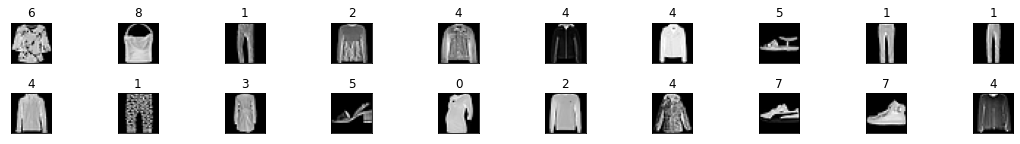

In [13]:
fig = plt.figure(figsize=(15,5))
for i in range(20):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img_temp[i]), cmap='gray')
    ax.set_title(label_temp[i].item())
    fig.tight_layout()

# Training Neural Networks

## Define Neural Networks

### Check in-/output dimensionality

In [14]:
img_temp[0].shape

torch.Size([1, 28, 28])

In [15]:
N_feature = np.prod(img_temp[0].shape)
N_feature

784

In [16]:
N_class = 10

In [17]:
model = torch.nn.Sequential(torch.nn.Linear(N_feature, 256), torch.nn.PReLU(),
                            torch.nn.Linear(256, 128),       torch.nn.PReLU(),
                            torch.nn.Linear(128, 64),        torch.nn.PReLU(),
                            torch.nn.Linear(64, N_class),    torch.nn.LogSoftmax(dim=1))
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

## Define loss function and optimizer

In [18]:
# Define the loss
Lossfunction = torch.nn.CrossEntropyLoss()
Lossfunction.to(device)

# Define the optimizer
Optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

## Define the training process

In [19]:
def train_nn(nn, train_loader, valid_loader, optimizer, lossfunction, Epoch=10**10):
    # dir for save temporary files
    if not os.path.exists('./temp'):
        os.mkdir('./temp')
    
    # create an unique ID for saving temp file, avoiding file overwriting while multiple training
    training_ID = ts = int(calendar.timegm(time.gmtime()))
    print(f'The ID for this training is {training_ID}.')
    
    # initialize best valid loss for saving the best model
    best_valid_loss = 10 ** 10
    
    # arrays to save training process
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    # to count the epoch without any improvement, for early stop
    not_imporved = 0
    
    # training
    for epoch in range(Epoch):
        # timer
        start_time = datetime.now()
        
        # some temp variables to calculate the loss and acc from mini-batch to batch
        num_of_mini_batch  = []
        loss_of_mini_batch = []
        acc_of_mini_batch  = []
        for X_train, y_train in train_loader:
            # reshape 2D images into 1D, also transfer to device
            X_train = X_train.view(X_train.shape[0], -1).to(device)
            y_train = y_train.to(device)
            
            # forward propagation
            prediction_train = nn(X_train)
            
            # calculate loss
            train_loss_mini_batch = lossfunction(prediction_train, y_train)

            # calculate predicted class of input data
            yhat_train = torch.argmax(prediction_train.data, 1)
            
            # calculate how many predictions are correct
            train_correct = torch.sum(yhat_train == y_train.data)
            
            # calculate accuracy of prediction
            train_acc_mini_batch = train_correct / y_train.numel()

            # update parameters in model
            optimizer.zero_grad()
            train_loss_mini_batch.backward()
            optimizer.step()

            # loss and acc from mini-batch
            num_of_mini_batch.append(X_train.shape[0])
            loss_of_mini_batch.append(train_loss_mini_batch.item())
            acc_of_mini_batch.append(train_acc_mini_batch.item())

        # convert and record loss/acc from mini-batch to batch
        train_loss = np.average(loss_of_mini_batch, weights=num_of_mini_batch)
        train_losses.append(train_loss)
        train_acc = np.average(acc_of_mini_batch, weights=num_of_mini_batch)
        train_accs.append(train_acc)

        # similar as training, calculate loss and accuracy on valid data
        num_of_mini_batch  = []
        loss_of_mini_batch = []
        acc_of_mini_batch  = []
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid = X_valid.view(X_valid.shape[0], -1).to(device)
                y_valid = y_valid.to(device)
                prediction_valid = nn(X_valid) 
                valid_loss_mini_batch = lossfunction(prediction_valid, y_valid).data
                yhat_valid = torch.argmax(prediction_valid.data, 1)
                valid_correct = torch.sum(yhat_valid == y_valid.data)
                valid_acc_mini_batch = valid_correct / y_valid.numel()

                num_of_mini_batch.append(X_valid.shape[0])
                loss_of_mini_batch.append(valid_loss_mini_batch.item())
                acc_of_mini_batch.append(valid_acc_mini_batch.item())

            valid_loss = np.average(loss_of_mini_batch, weights=num_of_mini_batch)
            valid_losses.append(valid_loss)
            valid_acc = np.average(acc_of_mini_batch, weights=num_of_mini_batch)
            valid_accs.append(valid_acc)

        # if valid loss in current epoch is better than previous one, save this model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(nn, f'./temp/NN_temp_{training_ID}')
            random_state = torch.random.get_rng_state()
            torch.save(random_state, f'./temp/NN_temp_random_state_{training_ID}')
            not_imporved = 0
        # if not, that means in this epoch, the model is not improved.
        else:
            not_imporved += 1
            if not_imporved > 5:
                print('Early stop.')
                break
        
        # timer
        end_time = datetime.now()
        
        # print information about current epoch
        if epoch % 1 == 0:
            print(f'| Epoch: {epoch:-5d} | Train acc: {train_acc:-.5f} | Train loss: {train_loss:-.5e} | Valid acc: {valid_acc:-.5f} | Valid loss: {valid_loss:-.5e} | run time: {end_time-start_time} |')
            
    print('Finished.')
    
    return torch.load(f'./temp/NN_temp_{training_ID}'), train_losses, valid_losses, train_accs, valid_accs

In [ ]:
model, train_loss, valid_loss, train_acc, valid_acc = train_nn(model, train_loader, valid_loader, Optimizer, Lossfunction)

The ID for this training is 1653076163.
| Epoch:     0 | Train acc: 0.43440 | Train loss: 1.82619e+00 | Valid acc: 0.61150 | Valid loss: 1.28733e+00 | run time: 0:00:08.918426 |
| Epoch:     1 | Train acc: 0.69377 | Train loss: 1.01166e+00 | Valid acc: 0.72475 | Valid loss: 8.30461e-01 | run time: 0:00:07.652079 |
| Epoch:     2 | Train acc: 0.74035 | Train loss: 7.55253e-01 | Valid acc: 0.74117 | Valid loss: 7.00756e-01 | run time: 0:00:07.617769 |
| Epoch:     3 | Train acc: 0.75806 | Train loss: 6.68610e-01 | Valid acc: 0.75808 | Valid loss: 6.42954e-01 | run time: 0:00:07.611123 |
| Epoch:     4 | Train acc: 0.77196 | Train loss: 6.23318e-01 | Valid acc: 0.76892 | Valid loss: 6.08037e-01 | run time: 0:00:07.786676 |
| Epoch:     5 | Train acc: 0.78340 | Train loss: 5.93054e-01 | Valid acc: 0.78092 | Valid loss: 5.84810e-01 | run time: 0:00:07.808827 |
| Epoch:     6 | Train acc: 0.79344 | Train loss: 5.70216e-01 | Valid acc: 0.78767 | Valid loss: 5.62175e-01 | run time: 0:00:07.934

In [ ]:
plt.plot(train_loss, label='train loss');
plt.plot(valid_loss, label='valid loss');
plt.xlabel('epoch')
plt.xlabel('loss')
plt.title('Loss of training')
plt.legend();

In [ ]:
plt.plot(train_acc, label='train acc');
plt.plot(valid_acc, label='valid acc');
plt.xlabel('epoch')
plt.xlabel('accuracy')
plt.title('Acc of training')
plt.legend();

In [ ]:
num_of_mini_batch  = []
loss_of_mini_batch = []
acc_of_mini_batch  = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.view(X_test.shape[0], -1).to(device)
        y_test = y_test.to(device)
        prediction_test = model(X_test) 
        test_loss_mini_batch = Lossfunction(prediction_test, y_test).data
        yhat_test = torch.argmax(prediction_test.data, 1)
        test_correct = torch.sum(yhat_test == y_test.data)
        test_acc_mini_batch = test_correct / y_test.numel()

        num_of_mini_batch.append(X_test.shape[0])
        loss_of_mini_batch.append(test_loss_mini_batch.item())
        acc_of_mini_batch.append(test_acc_mini_batch.item())

    test_loss = np.average(loss_of_mini_batch, weights=num_of_mini_batch)
    test_acc = np.average(acc_of_mini_batch, weights=num_of_mini_batch)

test_acc, test_loss

## Save trained model

In [ ]:
if not os.path.exists('./result'):
        os.mkdir('./result')
torch.save(model, './result/MyModel.nn')